In [1]:
import importlib
import draw_idt
importlib.reload(draw_idt)
from draw_idt import make_single_idt

import numpy as np
from math import pi
from math import pi
from gdshelpers.geometry.chip import Cell

-20
72.5
5.0


/opt/miniconda3/envs/torch/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/opt/miniconda3/envs/torch/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


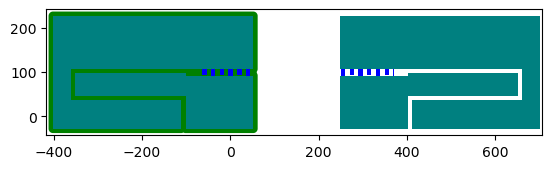

In [2]:
cell = Cell('IDT')
cell = make_single_idt(cell, pos=[50, 100], zno=True,
                        aperture=15, pair_num=50, pitch=2.4, finger_bias=0.01,
                        pair=True, pair_distance=200, displacement=0, )
cell.show()

In [40]:
cell.save('IDT_library_GDS/IDT_new/new_idt.gds')